<a href="https://colab.research.google.com/github/zelal-Eizaldeen/project2_Walmart_Price_Prediction/blob/main/project4_3113_zelalae2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project4: **Building a Movie Recommender System**

#**Team Members**
Zilal Eiz Aldin (Online MCS) Zelalae2@illinois.edu

Mesay Taye (Online MCS) mesayst2@illinois.edu

Jianci Zhai (Online MCS) jianciz2@illinois.edu

#**Contribution of each member**
- **Jianci**: Built (System II: Recommendation Based on IBCF), Genberated Similarity Matrix, Tested the IBCF function.

- **Messay**: Bublished the Frontend and the Backend using Docker.

- **Zilal**: Built System 1 (Recommendation Based on Popularity), used Dash to display top 10 movies, Published the System 1 using Render and Reported the System 1 on the Python Notebook.

#**Resources**
- EDA https://liangfgithub.github.io/Python_W13_Movie_RS.html


#**Libraries**

In [39]:
import pandas as pd
import numpy as np

import os
from IPython.display import Image, display


In [41]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [95]:
# Please insert your path for the Dataset and ImagesOfMovies
# DATA_DIR="/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/Projects/project4/Dataset/ml-1m"
DATA_DIR="ml-1m"



In [94]:
# Please insert your path for the Images
# POSTER_URL="/content/drive/MyDrive/MastersDegree/CS598 PSL/Assignments/Projects/project4/Solution/Notebook/assets"
POSTER_URL="MovieImages"

#**Loading the data**

In [78]:
ratings = pd.read_csv(f'{DATA_DIR}/ratings.dat', sep='::', engine = 'python', header=None)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies = pd.read_csv(f'{DATA_DIR}/movies.dat', sep='::', engine = 'python',
                     encoding="ISO-8859-1", header = None)
movies.columns = ['MovieID', 'Title', 'Genres']


In [79]:
# Add The images
movies['PosterURL'] = movies['MovieID'].apply(lambda x: f"{POSTER_URL}/{x}.jpg")


In [80]:
movies['PosterURL']

,PosterURL
0,/content/drive/MyDrive/MastersDegree/CS598 PSL...
1,/content/drive/MyDrive/MastersDegree/CS598 PSL...
2,/content/drive/MyDrive/MastersDegree/CS598 PSL...
3,/content/drive/MyDrive/MastersDegree/CS598 PSL...
4,/content/drive/MyDrive/MastersDegree/CS598 PSL...
...,...
3878,/content/drive/MyDrive/MastersDegree/CS598 PSL...
3879,/content/drive/MyDrive/MastersDegree/CS598 PSL...
3880,/content/drive/MyDrive/MastersDegree/CS598 PSL...
3881,/content/drive/MyDrive/MastersDegree/CS598 PSL...


#**EDA**
Explore the relationship between movie ratings and movie genres. First,
simplify movie genres: multiple genres to ‘Multiple’.

In [81]:
multiple_idx = pd.Series([("|" in movie) for movie in movies['Genres']])
movies.loc[multiple_idx, 'Genres'] = 'Multiple'

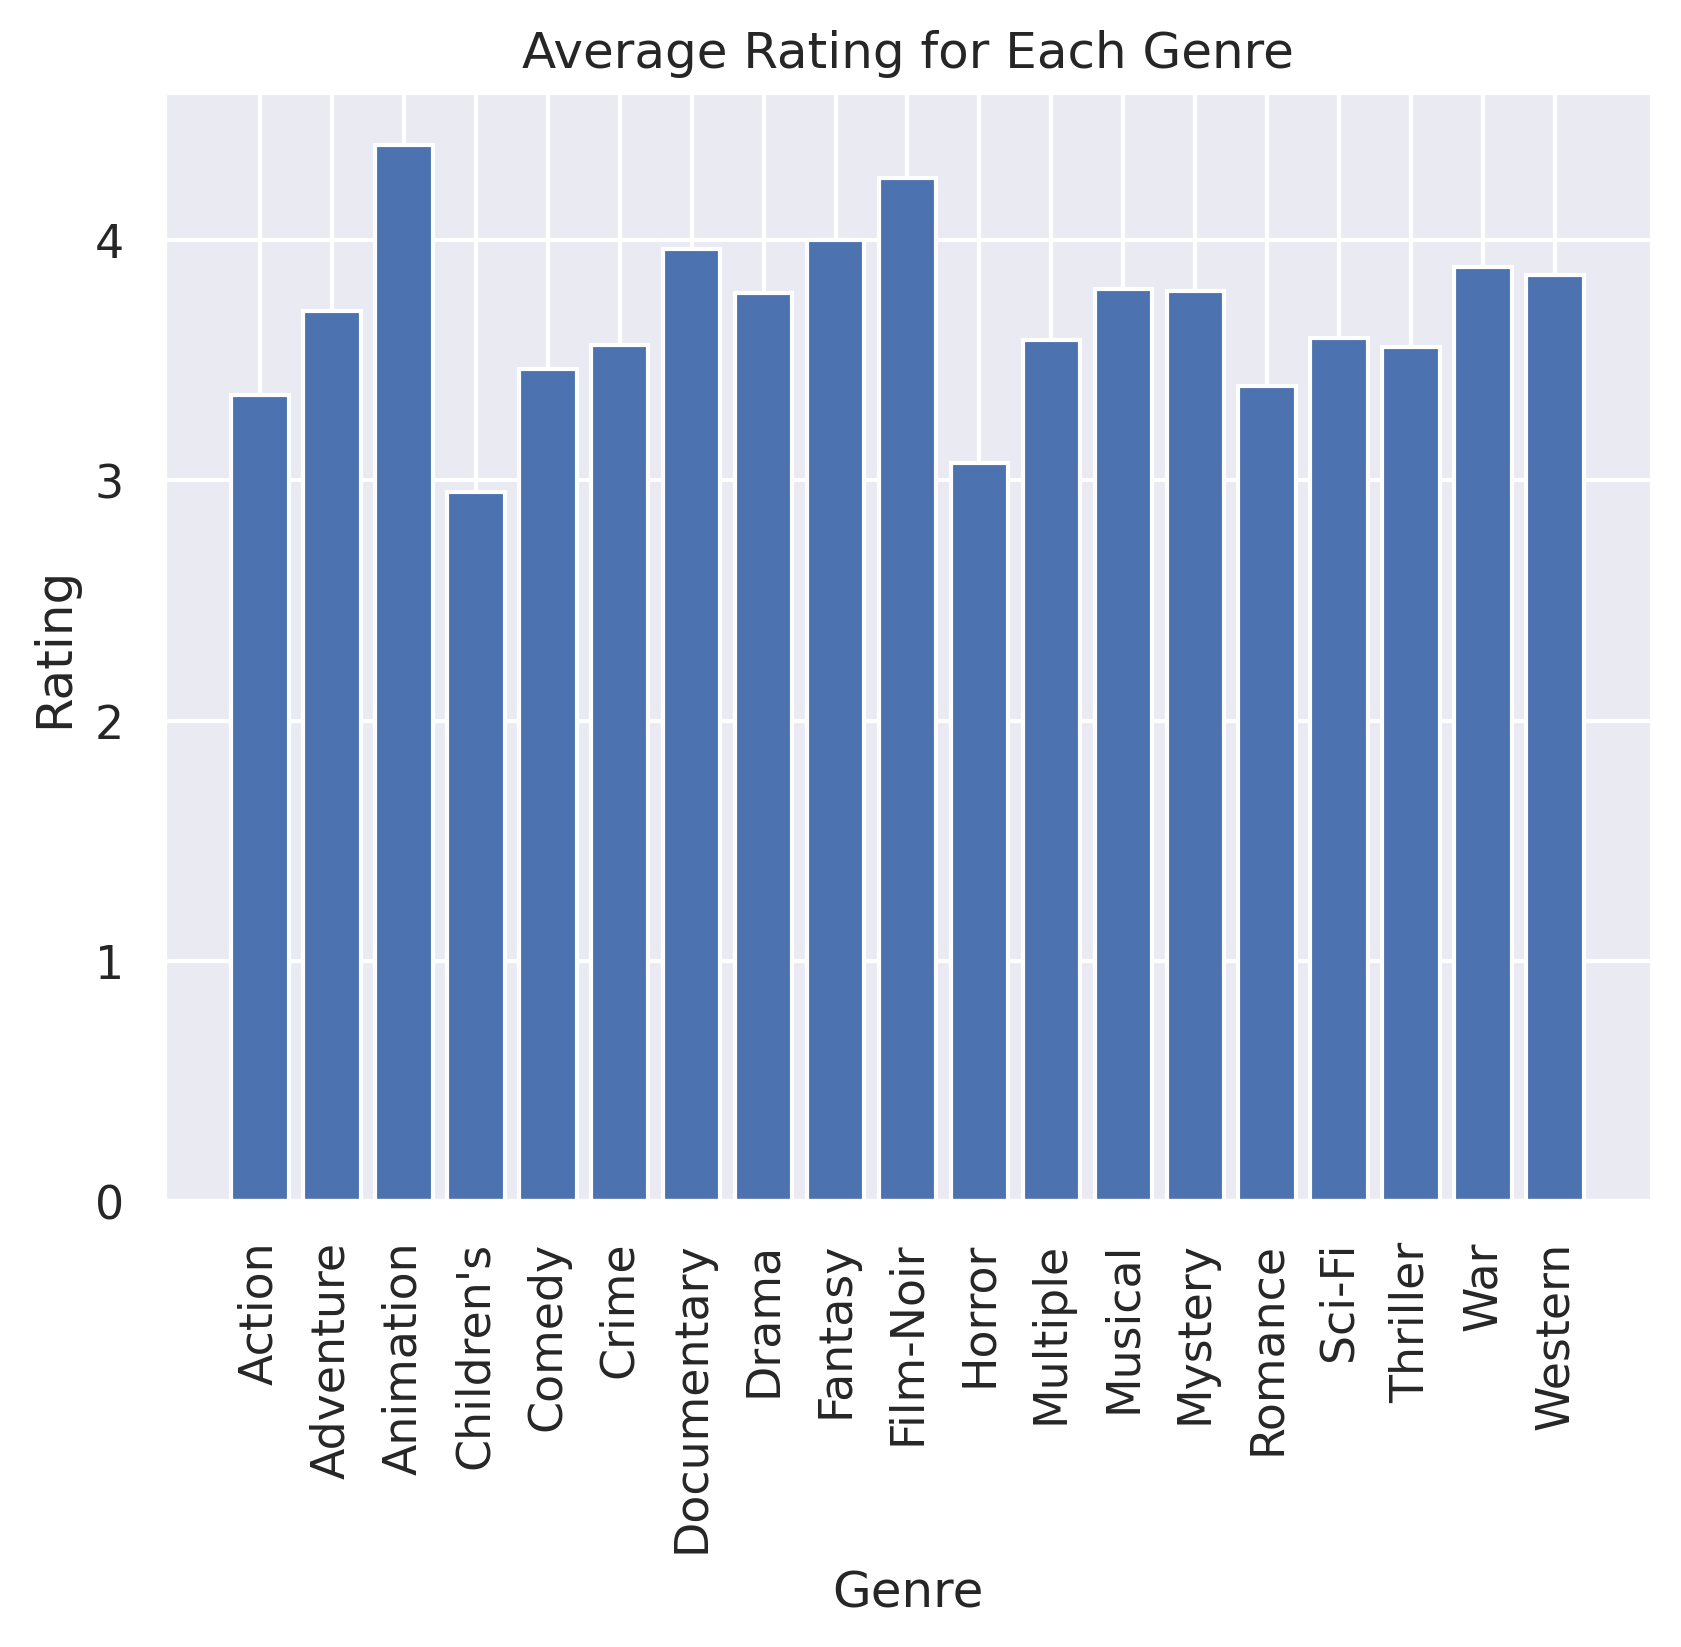

In [82]:
# Merge ratings and movie datasets.
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 300
sns.set()

rating_merged = ratings.merge(movies, left_on = 'MovieID', right_on = 'MovieID')
mean_ratings = rating_merged[['Rating', 'Genres']].groupby('Genres').mean()

plt.bar(mean_ratings.index, mean_ratings['Rating']);
plt.xticks(rotation=90);
plt.title('Average Rating for Each Genre');
plt.xlabel('Genre');
plt.ylabel('Rating');

#**Build System 1: Recommendation Based on Popularity**

#Compute Popularity Scores
To compute the popularity score for each movie, the following formula is used:

**Popularity Score=(Number of Ratings)×(Normalized Average Rating)**  Where:

- Normalized Average Rating: the average rating is normalized to a 0-1 scale (e.g., a rating scale from 1 to 5).
- Number of Ratings: This is the count of how many ratings a movie has received.

In [83]:
# Compute popularity scores with memory optimizations
rating_merged = ratings.merge(movies[['MovieID', 'Title']], on='MovieID')
movie_stats = rating_merged.groupby('MovieID').agg(
    num_ratings=('Rating', 'count'),
    avg_rating=('Rating', 'mean')
).reset_index()

In [84]:
movie_stats['normalized_rating'] = (movie_stats['avg_rating'] - 1) / 4
movie_stats['popularity_score'] = movie_stats['num_ratings'] * movie_stats['normalized_rating']


In [85]:
# Merge with movie titles to get more useful information
movie_popularity = movie_stats.merge(movies[['MovieID', 'Title','PosterURL']], on='MovieID')
# Sort by popularity score and select the top 10 movies
top_10_popular_movies = movie_popularity.sort_values(by='popularity_score', ascending=False).head(10)
# Display the top 10 popular movies
print(top_10_popular_movies[['MovieID', 'Title', 'num_ratings', 'avg_rating', 'popularity_score']])

      MovieID                                              Title  num_ratings  avg_rating  \
2651     2858                             American Beauty (1999)         3428    4.317386   
253       260          Star Wars: Episode IV - A New Hope (1977)         2991    4.453694   
1106     1196  Star Wars: Episode V - The Empire Strikes Back...         2990    4.292977   
1848     2028                         Saving Private Ryan (1998)         2653    4.337354   
1108     1198                     Raiders of the Lost Ark (1981)         2514    4.477725   
1120     1210  Star Wars: Episode VI - Return of the Jedi (1983)         2883    4.022893   
579       593                   Silence of the Lambs, The (1991)         2578    4.351823   
2374     2571                                 Matrix, The (1999)         2590    4.315830   
2557     2762                            Sixth Sense, The (1999)         2459    4.406263   
593       608                                       Fargo (1996)      

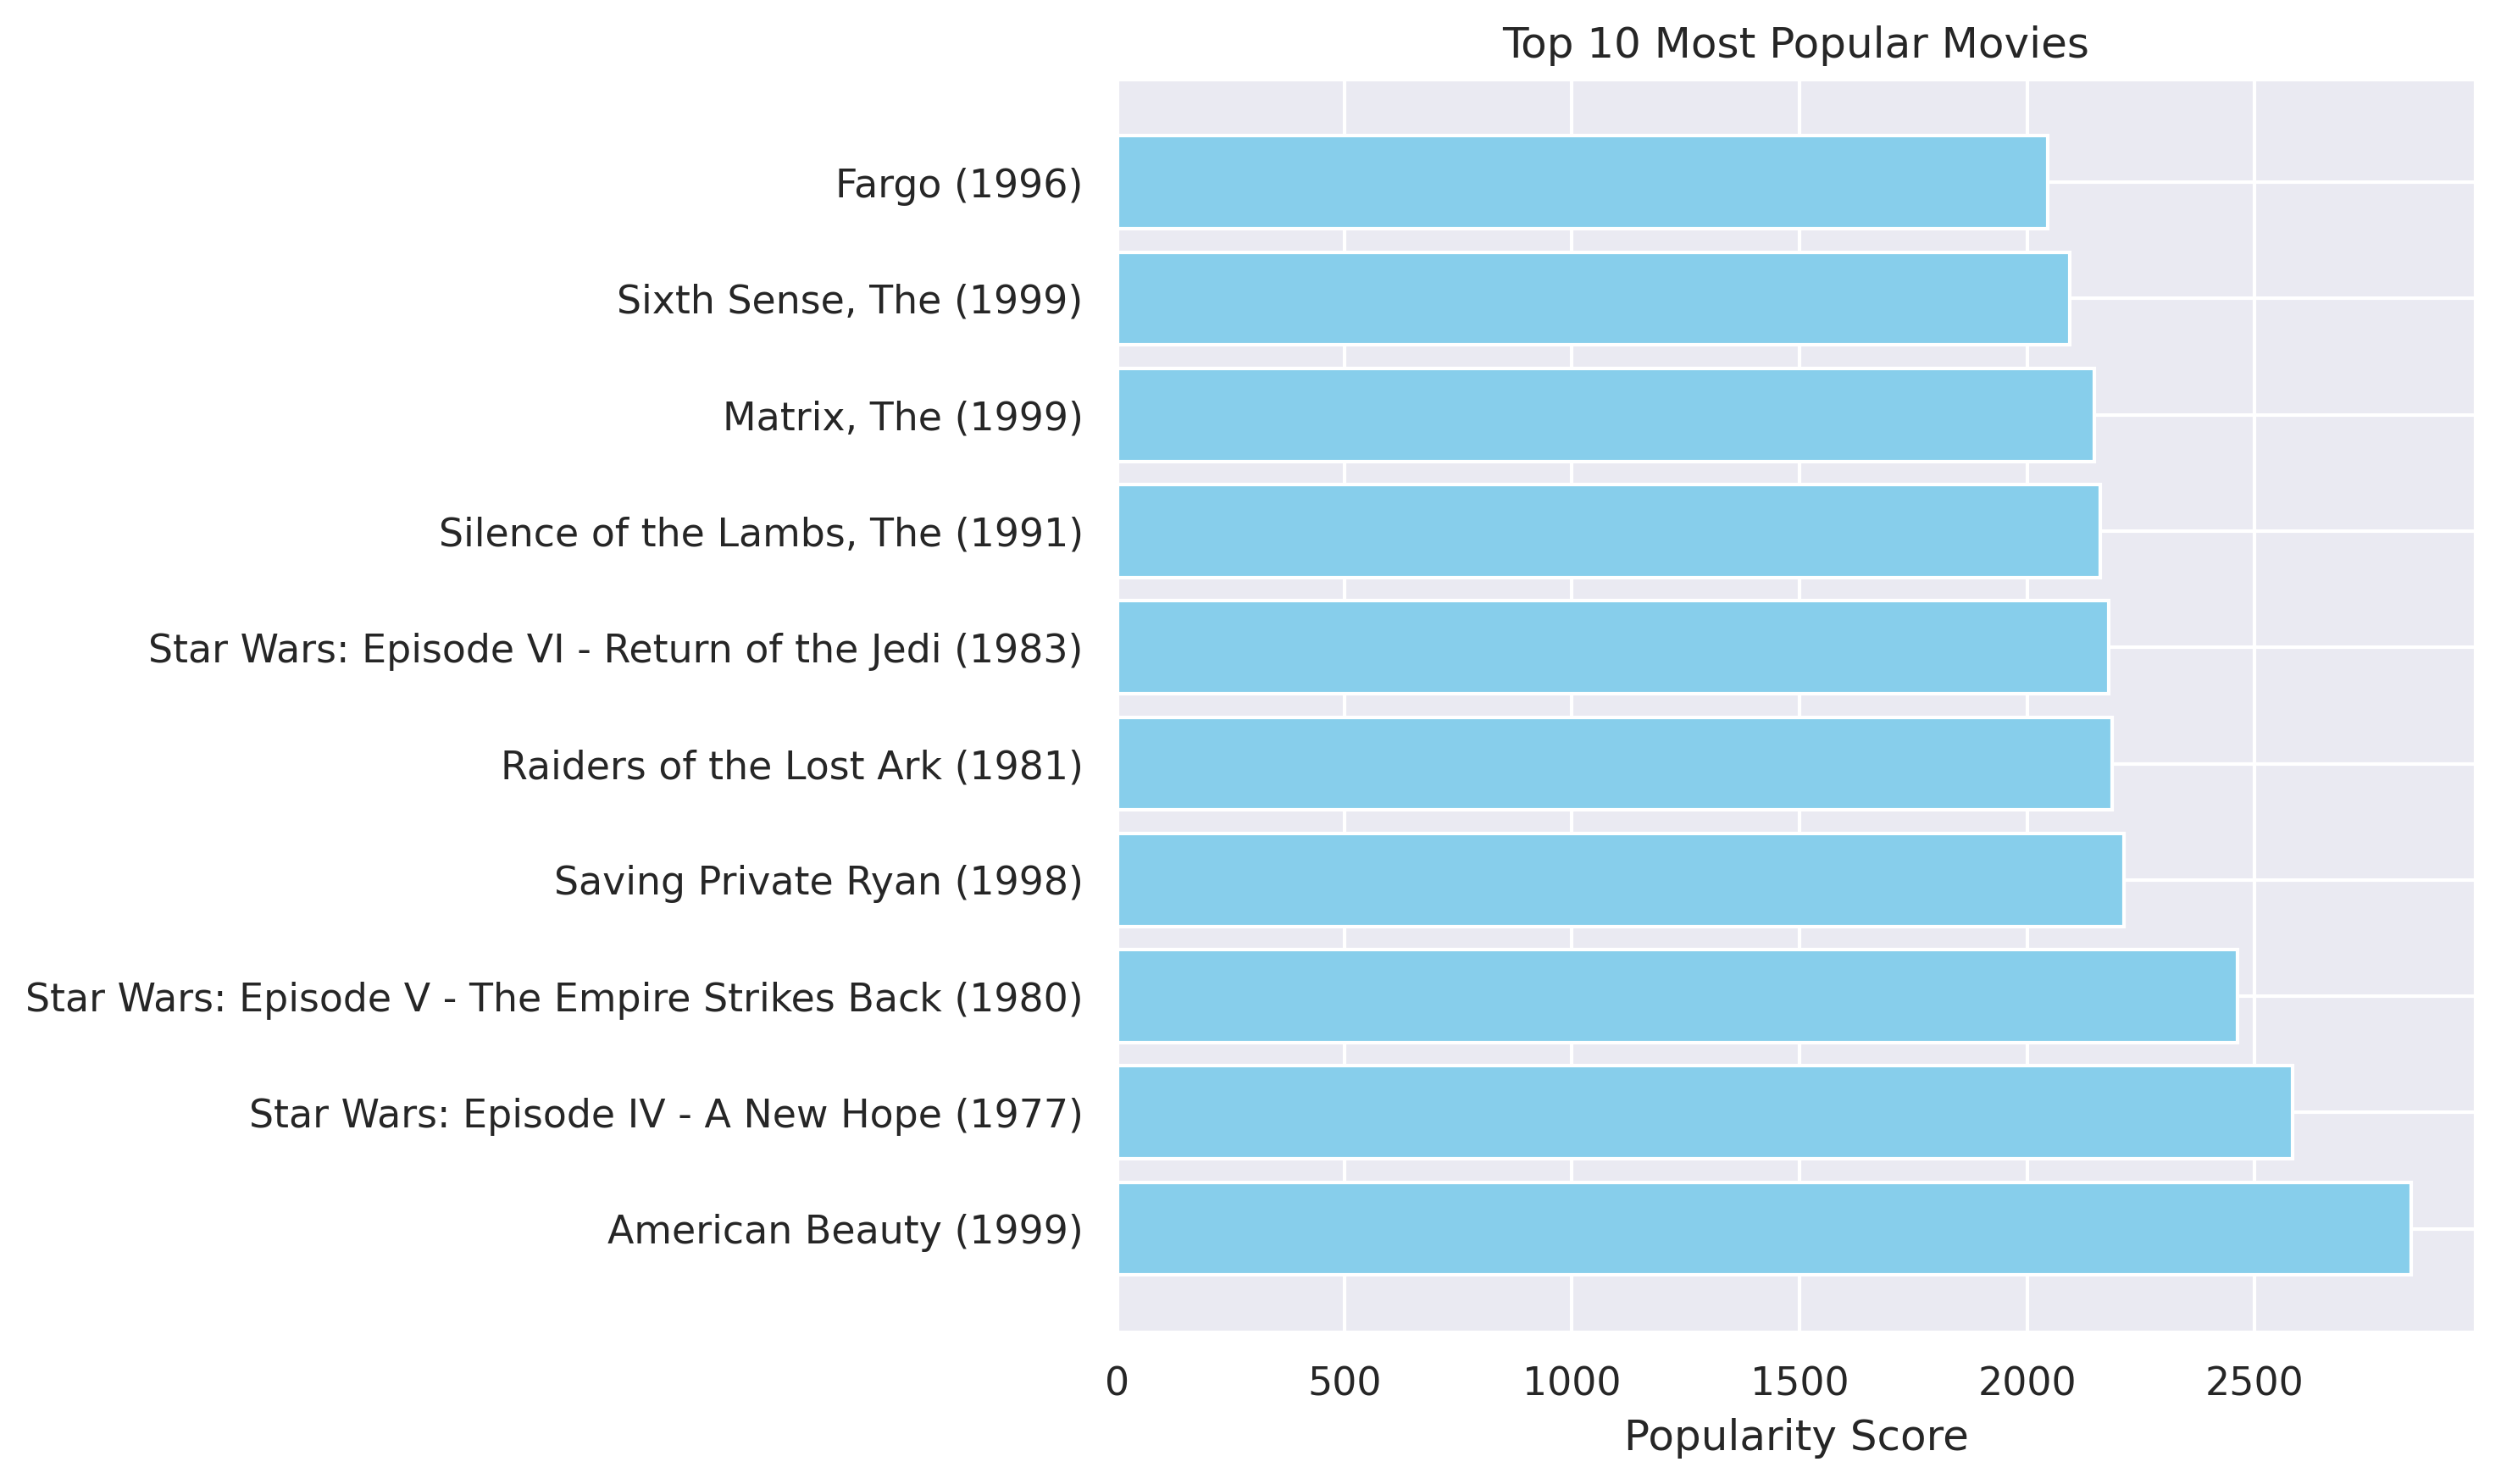

In [86]:
# Visualize the Top 10 Popular Movies
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(top_10_popular_movies['Title'], top_10_popular_movies['popularity_score'], color='skyblue')
ax.set_xlabel('Popularity Score')
ax.set_title('Top 10 Most Popular Movies')
plt.tight_layout()
plt.show()

MovieID: 2858.00
Title: American Beauty (1999)


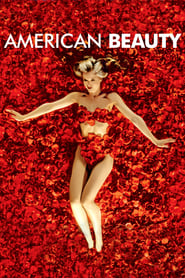



MovieID: 260.00
Title: Star Wars: Episode IV - A New Hope (1977)


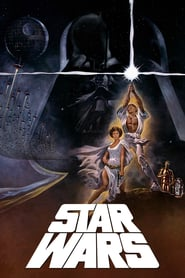



MovieID: 1196.00
Title: Star Wars: Episode V - The Empire Strikes Back (1980)


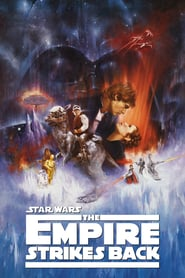



MovieID: 2028.00
Title: Saving Private Ryan (1998)


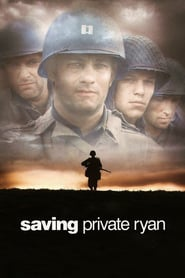



MovieID: 1198.00
Title: Raiders of the Lost Ark (1981)


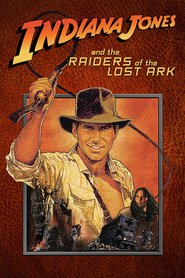



MovieID: 1210.00
Title: Star Wars: Episode VI - Return of the Jedi (1983)


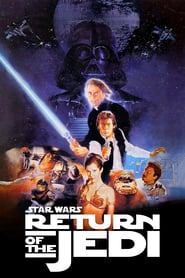



MovieID: 593.00
Title: Silence of the Lambs, The (1991)


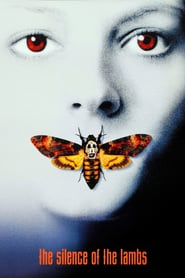



MovieID: 2571.00
Title: Matrix, The (1999)


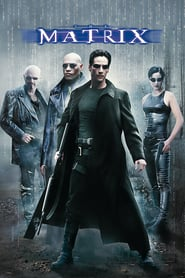



MovieID: 2762.00
Title: Sixth Sense, The (1999)


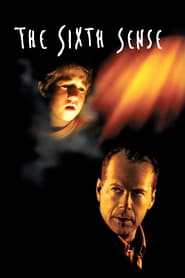



MovieID: 608.00
Title: Fargo (1996)


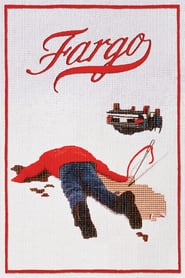

In [92]:
# Display movies with poster images in Google Colab
for index, row in top_10_popular_movies.iterrows():
    movie_id = row['MovieID']
    movie_title = row['Title']

    # Construct the image path based on movieId (e.g., movieId.jpg)
    image_path = os.path.join(POSTER_URL, f"{movie_id}.jpg")  # Adjust file extension if needed

    #Display MovieID
    print(f"MovieID: {movie_id:.2f}")
    # Display the movie title, rating, and image
    print(f"Title: {movie_title}")

    if os.path.exists(image_path):
        display(Image(image_path, width=200, height=300))  # Display movie poster
    else:
        print("No image found!")

    print("\n" + "="*50 + "\n")

#**System II: Recomendation Based on IBCF**

#**To Be completed By Jiance**

In [ ]:
# Create rating matrix
rating_matrix = ratings.pivot(index='UserID', columns='MovieID', values='Rating')
rating_matrix.index = ['u' + str(item) for item in rating_matrix.index.tolist()]

# Normalize rating matrix
rating_matrix_norm = rating_matrix.sub(rating_matrix.mean(axis=1, skipna=True), axis=0)



#**Link to Live App**


https://p4.fly.dev/

#**Link for The source Code of the Running App**

https://github.com/mesaystaye/p4